If you are using VSCode, simply clone the repository in a container volume. Otherwise, you'll need standard Anaconda packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Helper functions for later

In [2]:
def get_dispatch(market, intercept, slope):
    return np.maximum(
        np.minimum(
            intercept + slope*market.Bid - market.Capacity.cumsum().shift(fill_value=0),
            market.Capacity
        ),
        0
    )

def visualize(market, intercept, slope, ax):
    ax.step(market.Capacity.cumsum(), market.Bid, where='pre')
    ax.plot([intercept + slope*market.Bid.max(), intercept], [market.Bid.max(), 0])
    dispatched = market.loc[market.Dispatch > 0]
    ax.hlines(
        (dispatched['Total Marginal Cost'] + dispatched.Surplus/dispatched.Dispatch).mean(),
        ax.get_xlim()[0], ax.get_xlim()[1],
        color='black',
        linestyle='dashed'
    )
    ax.grid()

Load and process portfolio data

In [3]:
portfolios = pd.read_excel('ESG Portfolios.xlsx')
portfolios.columns = portfolios.iloc[0:3].bfill().iloc[0]
portfolios = portfolios.iloc[3:]
portfolios = portfolios[portfolios['UNIT NAME'] != 'Totals']
portfolios.dropna(axis='index', how='all', inplace=True)
portfolios.dropna(axis='columns', how='all', inplace=True)
portfolios['portfolio'] = (portfolios.isna().any(axis='columns') * portfolios['UNIT NAME']).replace('', np.NaN).ffill()
portfolios.dropna(axis='index', how='any', inplace=True)
portfolios.set_index(['Location', 'portfolio', 'UNIT NAME'], inplace=True)
portfolios.sort_index(axis='index',level=['Location', 'portfolio'], inplace=True)

Load and process profile data

In [4]:
profiles = pd.read_excel('ESG Demand Year 2.xlsx', header=2, index_col=[1,0,2])
profiles.dropna(axis='index', how='any', inplace=True)
profiles.sort_index(inplace=True)

``simulate`` accepts an hour and a bid, both of which are pandas ``Series`` objects with indices taken from the ``portfolios`` and ``profiles`` objects, respectively. It returns a copy of ``portfolios`` with dispatch and surplus results.

In [5]:
def simulate(hour, bid, transmission_capacity, co2_tax):

    results = portfolios.copy()
    results['Bid'] = bid
    results.sort_values('Bid', inplace=True)
    results['Dispatch'] = get_dispatch(results, hour.sum()['Load Intercept'], hour.sum()['Load Slope'])

    generation = results.Dispatch.groupby('Location').sum()
    consumption = np.linalg.inv(
        np.array(
            [
                np.array([1,-1])*np.array([1/hour.loc[location, 'Load Slope'] for location in hour.index]),
                [1, 1]
            ]
        )
    )@np.array(
        [
            np.array([1, -1])@(hour['Load Intercept']/hour['Load Slope']),
            results.Dispatch.sum()
        ]
    )
    shortage = consumption - generation

    if np.abs(shortage).mean() >= transmission_capacity:

        shortage = transmission_capacity*np.sign(shortage)
        results.Dispatch = results.groupby('Location', group_keys=False).apply(
            lambda market: get_dispatch(
                market, hour.loc[market.name, 'Load Intercept'] 
                - shortage[market.name], hour.loc[market.name, 'Load Slope']
            )
        )
        generation = results.Dispatch.groupby('Location').sum()
        consumption = generation + shortage

    price = (consumption - hour['Load Intercept'])/hour['Load Slope']

    results['Surplus'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Dispatch*(
            price[market.name] - market['Total Marginal Cost']
        ) 
    )

    results['Profit'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Surplus
        - market.Dispatch*(co2_tax*market.CO2) 
        - market['O&M/Day ($)']/4
    )
    return results

Simulate full year

In [6]:
results = profiles.groupby(['Day', 'Hour']).apply(
    lambda hour: simulate(
        hour = hour.droplevel(['Day', 'Hour']), 
        bid = portfolios['Total Marginal Cost'] + portfolios.CO2*(50 if hour.name[0] == 3 else 0),
        transmission_capacity = 500 if hour.name[0] == 2 else 10000,
        co2_tax = 50 if hour.name[0] == 3 else 0
    )
)

In [7]:
results.Profit.groupby('portfolio').sum()

portfolio
Bay Views        514675.425072
Beachfront       492553.366314
Big Coal         480119.738713
Big Gas          417571.503522
East Bay         272908.006724
Fossil Light    1250216.764889
Old Timers      1044485.947807
Name: Profit, dtype: object

Plot the north and south markets together. This kind of analysis makes sense for days 1, 2, and 4.

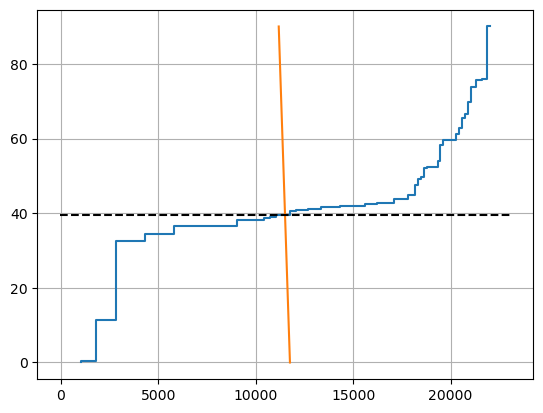

In [8]:
fig, ax = plt.subplots()
day = 1
hour = 1
hour_results = results.loc[day, hour]
(intercept, slope) = profiles.loc[(['North', 'South'], day, hour)].sum()
visualize(hour_results, intercept, slope, ax)
fig.show()

Plot the north and south markets seperately.

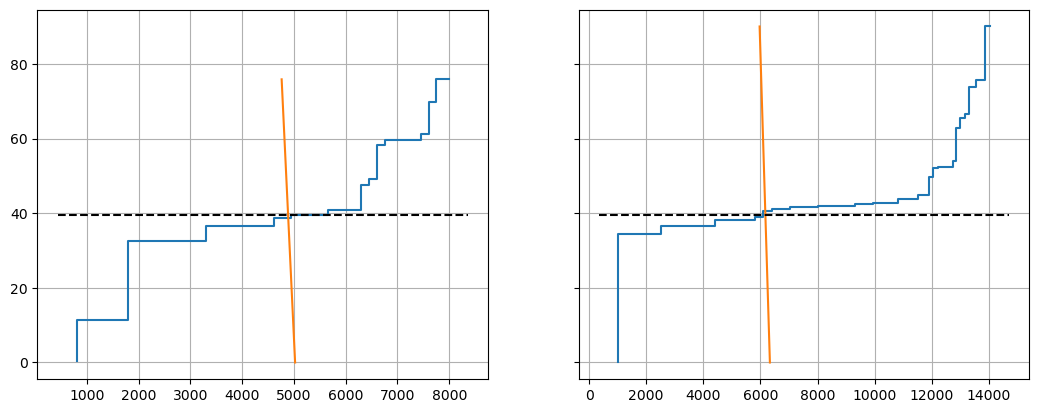

In [9]:
fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(fig.get_size_inches()*[2,1])
day = 2
hour = 1
hour_results = results.loc[day, hour]
(intercept, slope) = profiles.loc[(['North', 'South'], day, hour)]
[
    visualize(
        market, 
        profiles.loc[(location, day, hour),'Load Intercept'], 
        profiles.loc[(location, day, hour),'Load Slope'],  
        ax[i]
    ) 
    for i, (location, market) in enumerate(hour_results.groupby('Location'))
]
fig.show()